# Compare hologram data with MERRA2 on VAOD

- author Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date 2024-10-15
- last update 2024-10-17 with version v5
- last update : 2024-10-19 : Correct bugs on individual night curves
- last update : 2024-11-06 : Pressure effect
- Kernel @usdf **w_2024_37*
- Office emac : mamba_py311
- Home emac : base (conda)
- laptop : conda_py310

**Goal** : Show correlation holo /Merra

In [1]:
from platform import python_version
print(python_version())

3.10.15


In [2]:
import warnings
warnings.resetwarnings()
warnings.simplefilter('ignore')

In [3]:
from platform import python_version
print(python_version())

3.10.15


In [4]:
import os

In [5]:
# where are stored the figures
pathfigs = "figsHoloMerra2VAOD"
if not os.path.exists(pathfigs):
    os.makedirs(pathfigs) 
figtype = ".png"

In [6]:
import numpy as np
from numpy.linalg import inv
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.patches import Circle,Annulus
from astropy.visualization import ZScaleInterval
props = dict(boxstyle='round', facecolor="white", alpha=0.1)
#props = dict(boxstyle='round')

import matplotlib.colors as colors
import matplotlib.cm as cmx

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from matplotlib.gridspec import GridSpec

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy import constants as c

from astropy.coordinates.earth import EarthLocation
from datetime import datetime
from pytz import timezone

from scipy import interpolate
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KDTree, BallTree

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 100)

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

import scipy
from scipy.optimize import curve_fit,least_squares


# new color correction model
import pickle
from scipy.interpolate import RegularGridInterpolator

In [7]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time


In [8]:
# Remove to run faster the notebook
#import ipywidgets as widgets
#%matplotlib widget

In [9]:
from importlib.metadata import version

In [10]:
# wavelength bin colors
#jet = plt.get_cmap('jet')
#cNorm = mpl.colors.Normalize(vmin=0, vmax=NSED)
#scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
#all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

In [11]:
np.__version__

'2.1.2'

In [12]:
pd.__version__

'2.2.3'

In [13]:
def convertNumToDatestr(num):
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return pd.to_datetime(datestr)

### Configuration

In [14]:
observing_location = EarthLocation.of_site('Rubin Observatory')
tz = timezone('America/Santiago')

### Spectro Hologram data

In [15]:
FLAG_WITHCOLLIMATOR = True
DATE_WITHCOLLIMATOR = 20230930
datetime_WITHCOLLIMATOR = convertNumToDatestr(DATE_WITHCOLLIMATOR)
datetime_WITHCOLLIMATOR = pd.to_datetime("2023-09-30 00:00:00.0+0000")
datetime_WITHCOLLIMATOR

Timestamp('2023-09-30 00:00:00+0000', tz='UTC')

In [16]:
version_results = "v5"
legendtag = {"v1" : "old v3.1.0",
            "v2" : "v3.1.0-PWV<10mm",
            "v3" : "v3.1.0-PWV<15mm",
            "v4" : "Auxtel holo v3.1.0",
            "v5" : "Auxtel holo v3.1.0 09/22 - 10/24"}

In [17]:
atmfilenamesdict = {"v1" : "data/spectro/auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_testWithMaskedEdges_newBoundaries_newPolysRescaled_newFitBounds_adjustA1_lockedOrder2_removeThroughputTails_2.npy",
                    "v2" : "auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_lockedOrder2_FixA1_FixA2_FitAngstrom_FixA1_FixA2_FitAngstrom_WithGaia_freePressure_newThroughput6_BG40Scaled1.09_PeekFinder.npy",
                    "v3" : "u_dagoret_auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_lockedOrder2_FixA1_FixA2_FitAngstrom_WithGaia_freePressure_newThroughput6_BG40Scaled1.09_AtmoFitPressureA2_SpecErr_PeekFinder_20240924T161119Z.npy",
                    "v4" : "u_dagoret_auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_lockedOrder2_FixA1_FixA2_FitAngstrom_WithGaia_freePressure_newThroughput6_BG40Scaled1.09_AtmoFitPressureA2_SpecErr_PeekFinder_20240924T161119Z_spectrfullextend.npy",
                    "v5" : "u_dagoret_auxtel_atmosphere_202209_v3.1.0_doSensorFlat_rebin2_lockedOrder2_FixA1_FixA2_FitAngstrom_WithGaia_freePressure_newThroughput6_BG40Scaled1.09_AtmoFitPressureA2_SpecErr_No5SigmaClip_20241016T184601Z_spectrfullextended.npy"}

In [18]:
atmfilename = atmfilenamesdict[version_results]
tag = legendtag[version_results] 

### MERRA2

In [19]:
!ls ../SpectroMerra2/MerradataMerged

Merge_inst1_2d_asm_Nx_M2I1NXASM-2021-2024.csv
Merge_tavg1_2d_aer_Nx_M2T1NXAER-2021-2024.csv


In [20]:
filename_m2 = "../SpectroMerra2/MerradataMerged/Merge_tavg1_2d_aer_Nx_M2T1NXAER-2021-2024.csv"

In [21]:
df_m = pd.read_csv(filename_m2)

In [22]:
df_m

,Unnamed: 0,time,TOTANGSTR,TOTEXTTAU,TOTSCATAU,Time
0,0,2021-01-01 00:30:00,1.196867,0.056970,0.053770,2021-01-01 00:30:00
1,1,2021-01-01 01:30:00,1.198094,0.057817,0.054558,2021-01-01 01:30:00
2,2,2021-01-01 02:30:00,1.201883,0.060025,0.056720,2021-01-01 02:30:00
3,3,2021-01-01 03:30:00,1.209316,0.062329,0.059037,2021-01-01 03:30:00
4,4,2021-01-01 04:30:00,1.218950,0.064500,0.061218,2021-01-01 04:30:00
...,...,...,...,...,...,...
29179,5851,2024-09-01 19:30:00,1.647097,0.032741,0.029670,2024-09-01 19:30:00
29180,5852,2024-09-01 20:30:00,1.639555,0.032979,0.029950,2024-09-01 20:30:00
29181,5853,2024-09-01 21:30:00,1.629680,0.032491,0.029505,2024-09-01 21:30:00
29182,5854,2024-09-01 22:30:00,1.622610,0.031551,0.028597,2024-09-01 22:30:00


## Initialisation

### Read the file

In [23]:
specdata = np.load(atmfilename,allow_pickle=True)

In [24]:
df_spec = pd.DataFrame(specdata)

In [25]:
list(df_spec.columns)

['DATE-OBS',
 'id',
 'BITPIX',
 'NAXIS',
 'NAXIS1',
 'NAXIS2',
 'EXTEND',
 'TARGET',
 'REDSHIFT',
 'GRATING',
 'ROTANGLE',
 'D2CCD',
 'LSHIFT',
 'DOMEAZ',
 'AZ',
 'EL',
 'RA',
 'MJD',
 'WINDSPD',
 'WINDDIR',
 'PARANGLE',
 'TARGETX',
 'TARGETY',
 'LBDA_REF',
 'PSF_REG',
 'TRACE_R',
 'MEANFWHM',
 'PIXSHIFT',
 'CHI2_FIT',
 'A2_FIT',
 'AM_FIT',
 'VERSION',
 'CCD_REBIN',
 'CONFIG',
 'EXPTIME',
 'AIRMASS',
 'DEC',
 'HA',
 'OUTTEMP',
 'OUTPRESS',
 'OUTHUM',
 'FILTER',
 'CAM_ROT',
 'S_X0',
 'S_Y0',
 'S_XMIN',
 'S_XMAX',
 'S_YMIN',
 'S_YMAX',
 'S_NX',
 'S_NY',
 'S_DEG',
 'S_SAT',
 'S_ORDER',
 'A1_x',
 'A1_err_x',
 'A2_x',
 'A2_err_x',
 'A3',
 'A3_err',
 'VAOD_x',
 'VAOD_err_x',
 'angstrom_exp_x',
 'angstrom_exp_err_x',
 'ozone [db]_x',
 'ozone [db]_err_x',
 'PWV [mm]_x',
 'PWV [mm]_err_x',
 'B_x',
 'B_err_x',
 'A_star',
 'A_star_err',
 'D_CCD [mm]_x',
 'D_CCD [mm]_err_x',
 'shift_x [pix]',
 'shift_x [pix]_err',
 'shift_y [pix]',
 'shift_y [pix]_err',
 'angle [deg]',
 'angle [deg]_err',
 'P [hPa

### Define if a target is faint or bright

In [26]:
def IsFaint(row):
    List_Of_Faint_targets = ['Feige110','HD074000','HD115169','HD031128','HD200654','HD167060','HD009051','HD142331','HD160617','HD111980']
    List_Of_faint_selected = List_Of_Faint_targets[:10]
    if row["TARGET"] in List_Of_faint_selected:
        return True
    else:
        return False

In [27]:
df_spec["isFaint"] = df_spec.apply(IsFaint,axis=1)

### Compute NightObs

In [28]:
df_spec["nightObs"] = df_spec.apply(lambda x: x['id']//100_000, axis=1)

In [29]:
if FLAG_WITHCOLLIMATOR:
    df_spec = df_spec[df_spec["nightObs"]> DATE_WITHCOLLIMATOR]

## Apply Quality selection

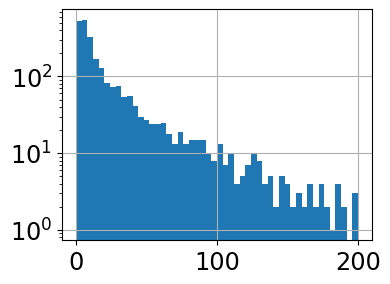

In [30]:
fig,ax = plt.subplots(1,1)
df_spec["CHI2_FIT"].hist(bins=50,ax=ax,range=(0,200))
ax.set_yscale("log")

### Add the Time in pd.datetime

### UTC

In [31]:
df_spec["Time"] = pd.to_datetime(df_spec["DATE-OBS"])

In [32]:
DT = pd.Timedelta(minutes=7*24*60)
TMIN  = df_spec["Time"].min()-DT
TMAX  = df_spec["Time"].max()+DT

### Compute relative time to Mid-night

In [33]:
def GetTimeToMidNight(row):
    observing_time = Time(row['DATE-OBS'], scale='utc', location=observing_location)

    # time at the location , either before or after midnight
    local_time =  observing_time.to_datetime(timezone=tz)

    # take time independent  of any location now
    local_time_new = datetime(local_time.year,local_time.month,local_time.day,local_time.hour,local_time.minute,local_time.second)
    local_time_midnight = datetime(local_time_new.year,local_time_new.month,local_time_new.day)
    dt_hour = (local_time_new -local_time_midnight).seconds/3600.

    # we took the previous night mid-night , must subtract 24H
    if dt_hour > 12.:
        dt_hour_new = (dt_hour - 24.)
    else:
        dt_hour_new = dt_hour
        
    return dt_hour_new

In [34]:
df_spec["dt_midnight"] = df_spec.apply(GetTimeToMidNight,axis=1)

Text(0.5, 1.0, 'Observation time')

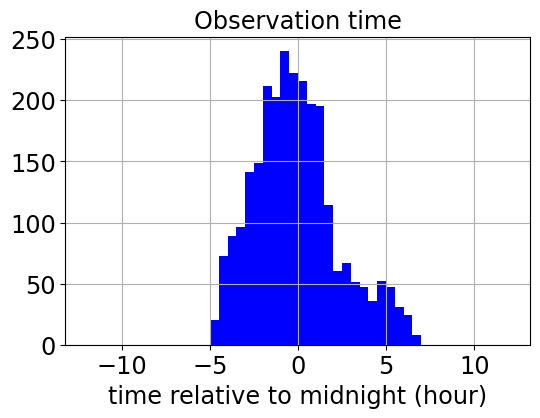

In [35]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
df_spec["dt_midnight"].hist(bins=48,range=(-12,12),ax=ax,facecolor="blue") 
ax.set_xlabel("time relative to midnight (hour)")
ax.set_title("Observation time")

### Compute Date relative to January

In [36]:
def GetDateToMidJanuary(row):
    observing_time = Time(row['DATE-OBS'], scale='utc', location=observing_location)

    # time at the location , either before or after midnight
    local_time =  observing_time.to_datetime(timezone=tz)

    # take time independent  of any location now
    local_time_new = datetime(2024,local_time.month,local_time.day,local_time.hour,local_time.minute,local_time.second)
           
    return pd.to_datetime(local_time_new)

In [37]:
#df_spec["Time_january"] = df_spec.apply(GetDateToMidJanuary,axis=1)

In [38]:
def GetDateToMidJanuaryAndYear(row):
    observing_time = Time(row['DATE-OBS'], scale='utc', location=observing_location)

    # time at the location , either before or after midnight
    local_time =  observing_time.to_datetime(timezone=tz)

    # take time independent  of any location now
    local_time_new = datetime(2024,local_time.month,local_time.day,local_time.hour,local_time.minute,local_time.second)
           
    return pd.to_datetime(local_time_new),local_time.year 

In [39]:
df_spec[["Time_january","Year"]] = df_spec.apply(GetDateToMidJanuaryAndYear,axis=1,result_type="expand")

In [40]:
df_spec[["Time_january","Year"]]

,Time_january,Year
3329,2024-10-10 23:02:25,2023
3330,2024-10-10 23:03:38,2023
3331,2024-10-10 23:25:46,2023
3332,2024-10-10 23:26:59,2023
3333,2024-10-10 23:34:11,2023
...,...,...
5914,2024-10-16 05:33:33,2024
5915,2024-10-16 05:41:00,2024
5916,2024-10-16 05:42:13,2024
5917,2024-10-16 05:49:45,2024


## Compute night boundaries

In [41]:
def GetNightBoundariesDict(df_spec):
    """
    input:
      df_spec the dataframe for spectroscopy summary results
    output:
      the dict of night boudaries
    """
    
    Dt = pd.Timedelta(minutes=30)
    d = {}
    list_of_nightobs = df_spec["nightObs"].unique()
    for nightobs in list_of_nightobs:
        sel_flag = df_spec["nightObs"]== nightobs
        df_night = df_spec[sel_flag]
        tmin = df_night["Time"].min()-Dt
        tmax = df_night["Time"].max()+Dt
        d[nightobs] = (tmin,tmax)
    return d

In [42]:
dn = GetNightBoundariesDict(df_spec)

## Plot all data

In [45]:
cut  = ~(df_spec["OUTPRESS"] == 743.00) 

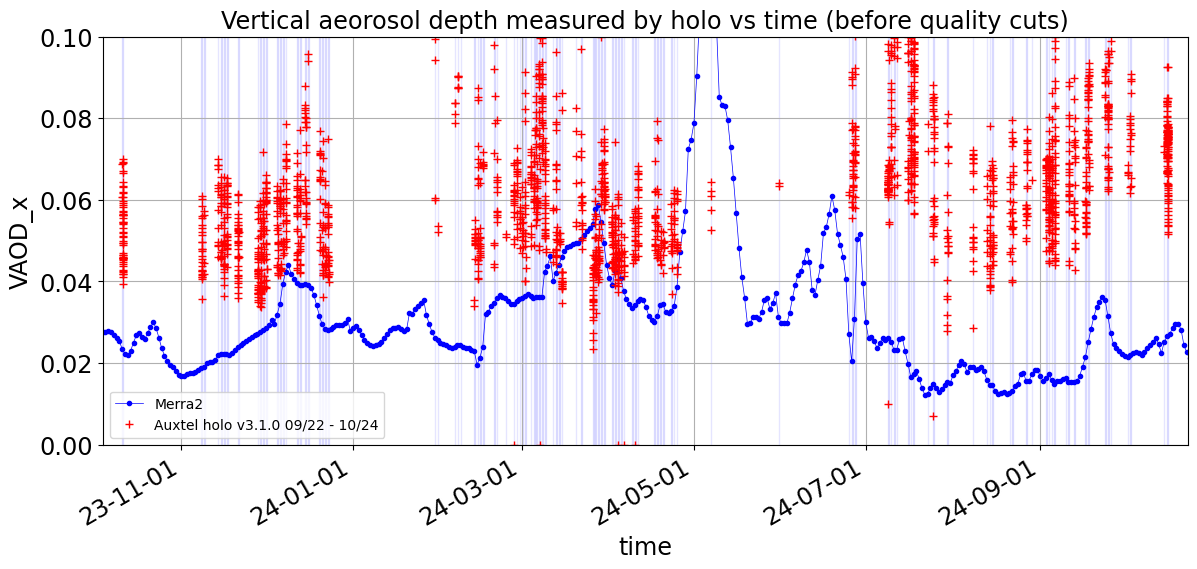

In [43]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%y-%m-%d")


fig,axs = plt.subplots(1,1,figsize=(14,6))
ax  = axs
leg=ax.get_legend()

ax.set_xlim(TMIN,TMAX) 
df_m.plot(x="Time",y="TOTEXTTAU",ax=ax,marker=".",c="b",lw=0.5,label="Merra2",legend=leg)   

df_spec.plot(x="Time",y="VAOD_x",ax=ax,marker='+',c="r",lw=0.0,grid=True,label=tag,legend=leg)
ax.set_ylabel("VAOD_x")

ax.set_xlabel("time")
ax.xaxis.set_major_formatter(date_form)
ax.set_title("Vertical aeorosol depth measured by holo vs time (before quality cuts)")
ax.legend()
ax.set_ylim(0.,0.1)




for key, tt in dn.items():
    ax.axvspan(tt[0],tt[1], color='blue', alpha=0.1)

if not FLAG_WITHCOLLIMATOR:
    ax.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)




figname =f"{pathfigs}/vaod_allpoints_allnights_nocuts"+figtype
plt.savefig(figname)
plt.show()

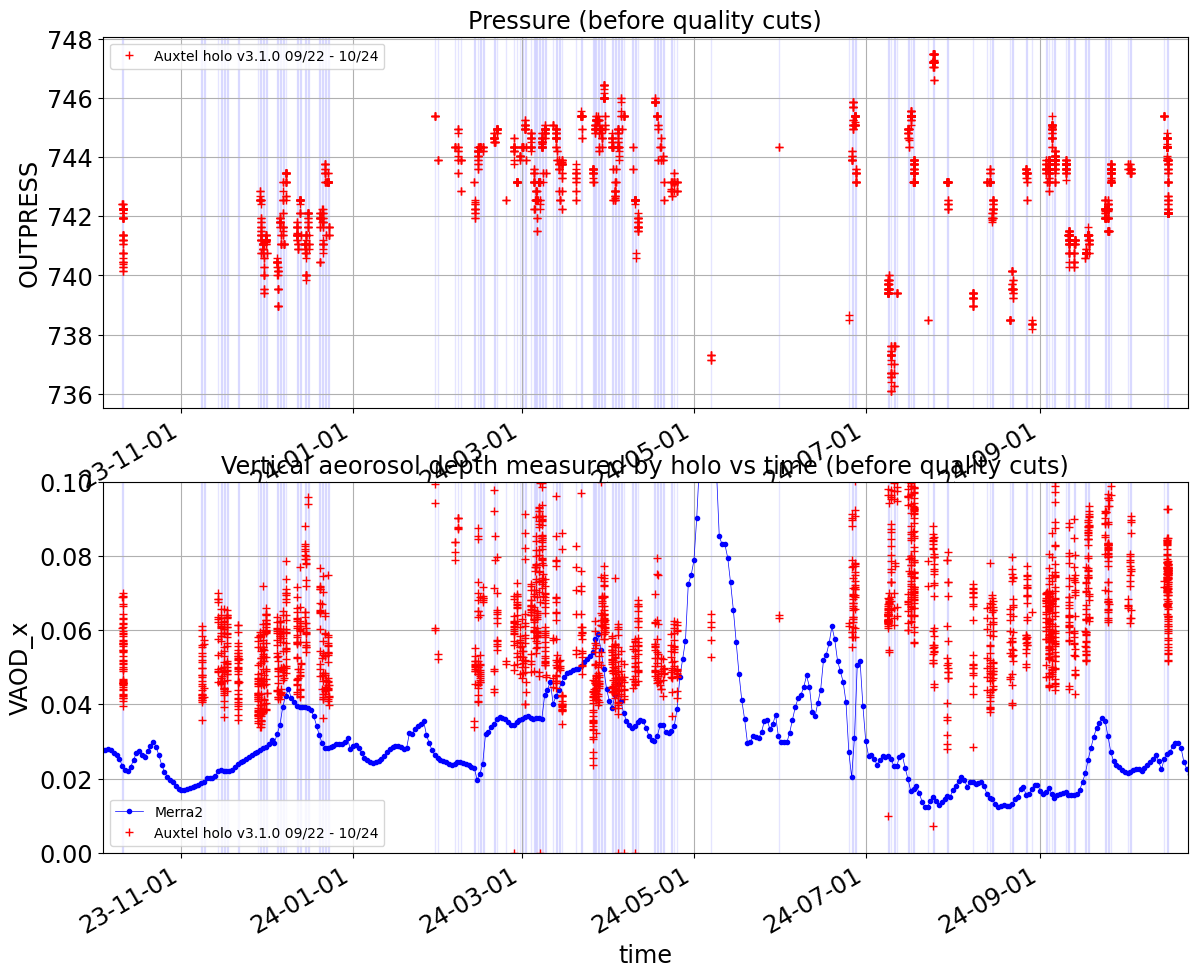

In [46]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%y-%m-%d")
fig,axs = plt.subplots(2,1,figsize=(14,12))
ax  = axs[0]
leg=ax.get_legend()

ax.set_xlim(TMIN,TMAX) 
#df_m.plot(x="Time",y="PShP",ax=ax,marker=".",c="b",lw=0.5,label="Merra2",ms=1,legend=leg)   
df_spec[cut].plot(x="Time",y="OUTPRESS",ax=ax,marker='+',c="r",lw=0.0,grid=True,label=tag,legend=leg)
ax.set_ylabel("OUTPRESS")

ax.set_xlabel("time")
ax.xaxis.set_major_formatter(date_form)
ax.set_title("Pressure (before quality cuts)")
ax.legend()

if not FLAG_WITHCOLLIMATOR:
    ax.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)


for key, tt in dn.items():
    ax.axvspan(tt[0],tt[1], color='blue', alpha=0.1)

ax  = axs[1]
#ax.set_ylim(0.,15.)
leg=ax.get_legend()

ax.set_xlim(TMIN,TMAX) 
df_m.plot(x="Time",y="TOTEXTTAU",ax=ax,marker=".",c="b",lw=0.5,label="Merra2",legend=leg)   

df_spec.plot(x="Time",y="VAOD_x",ax=ax,marker='+',c="r",lw=0.0,grid=True,label=tag,legend=leg)
ax.set_ylabel("VAOD_x")

ax.set_xlabel("time")
ax.xaxis.set_major_formatter(date_form)
ax.set_title("Vertical aeorosol depth measured by holo vs time (before quality cuts)")
ax.legend()
ax.set_ylim(0.,0.1)


for key, tt in dn.items():
    ax.axvspan(tt[0],tt[1], color='blue', alpha=0.1)

if not FLAG_WITHCOLLIMATOR:
    ax.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)

figname =f"{pathfigs}/vaodandpressure_allpoints_allnights_nocuts"+figtype
plt.savefig(figname)
plt.show()

(0.0, 0.2)

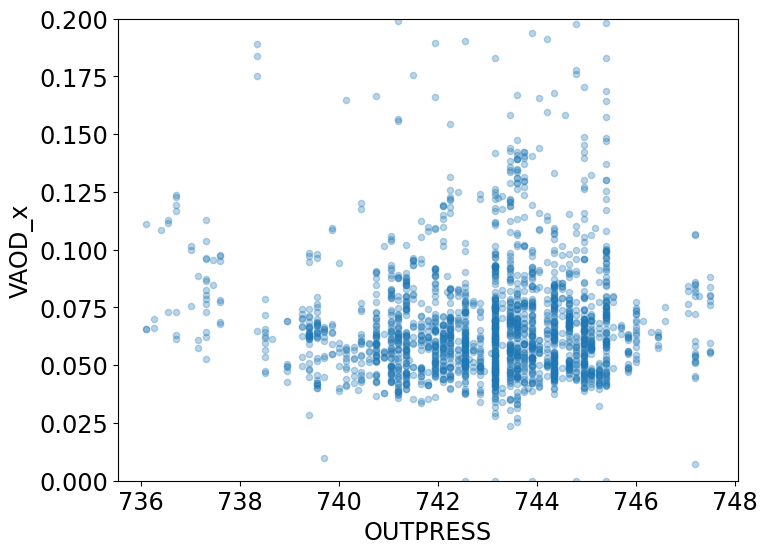

In [50]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
df_spec[cut].plot.scatter(y="VAOD_x",x="OUTPRESS",ax=ax,alpha=0.3)
ax.set_ylim(0.,0.2)

(500.0, 700.0)

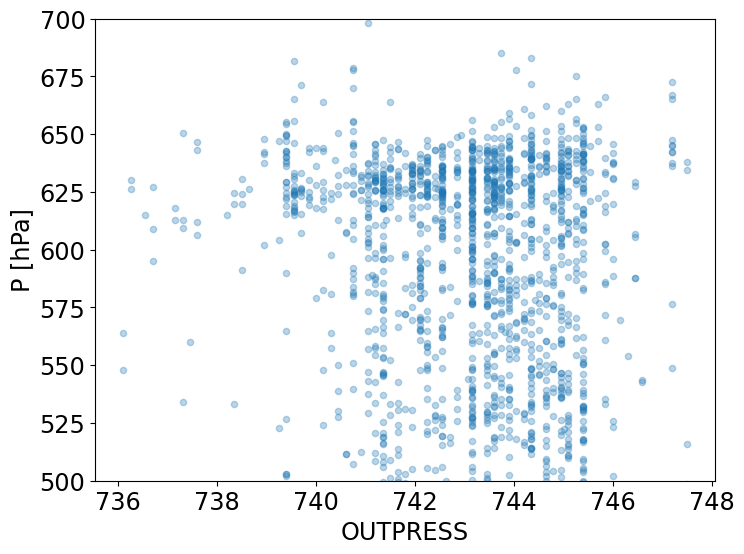

In [49]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
df_spec[cut].plot.scatter(y="P [hPa]",x="OUTPRESS",ax=ax,alpha=0.3)
ax.set_ylim(500,700)
#ax.set_ylim(0,700)

## Apply Quality selection cuts

In [ ]:
def getSelectionCutOld(df_spec, chi2max=20., pwvmin=0.1, pwvmax = 14.9):
    cut =  (df_spec["CHI2_FIT"]<chi2max) & (df_spec["PWV [mm]_x"] > pwvmin) & (df_spec["PWV [mm]_x"] < pwvmax) 
    return cut

In [ ]:
def getSelectionCut(df_spec, chi2max=20., pwvmin=0.1, pwvmax = 14.9,ozmin=100.,ozmax=600.):
    cut =  (df_spec["CHI2_FIT"]<chi2max) & (df_spec["PWV [mm]_x"] > pwvmin) & (df_spec["PWV [mm]_x"] < pwvmax) & (df_spec["D2CCD"]>186.5) &  (df_spec["D2CCD"]<187.3) & \
    (df_spec['EXPTIME'] > 20.) & (df_spec["PWV [mm]_y"] > pwvmin) & (df_spec["PWV [mm]_y"] < pwvmax) & \
    (df_spec["ozone [db]_y"] > ozmin) & (df_spec["ozone [db]_y"] < ozmax) 
    return cut

In [ ]:
def getSelectionCutNoPolar(df_spec, chi2max=20., pwvmin=0.1, pwvmax = 14.9,ozmin=100.,ozmax=600.):
    cut =  (df_spec["CHI2_FIT"]<chi2max) & (df_spec["PWV [mm]_x"] > pwvmin) & (df_spec["PWV [mm]_x"] < pwvmax) & (df_spec["D2CCD"]>186.5) &  (df_spec["D2CCD"]<187.3) & \
    (df_spec['EXPTIME'] > 20.) & (df_spec["PWV [mm]_y"] > pwvmin) & (df_spec["PWV [mm]_y"] < pwvmax) & \
    (df_spec["ozone [db]_y"] > ozmin) & (df_spec["ozone [db]_y"] < ozmax) & (df_spec["TARGET"] != "HD185975")
    return cut

In [ ]:
def getSelectionCutWithPolar(df_spec, chi2max=20., pwvmin=0.1, pwvmax = 14.9,ozmin=100.,ozmax=600.):
    cut =  (df_spec["CHI2_FIT"]<chi2max) & (df_spec["PWV [mm]_x"] > pwvmin) & (df_spec["PWV [mm]_x"] < pwvmax) & (df_spec["D2CCD"]>186.5) &  (df_spec["D2CCD"]<187.3) & \
    (df_spec['EXPTIME'] > 20.) & (df_spec["PWV [mm]_y"] > pwvmin) & (df_spec["PWV [mm]_y"] < pwvmax) & \
    (df_spec["ozone [db]_y"] > ozmin) & (df_spec["ozone [db]_y"] < ozmax) & (df_spec["TARGET"] == "HD185975")
    return cut

In [ ]:
cut = getSelectionCut(df_spec) 
cut_nopolar = getSelectionCutNoPolar(df_spec) 
cut_nopolar_bright = getSelectionCutNoPolar(df_spec) & (~df_spec["isFaint"])
cut_nopolar_faint = getSelectionCutNoPolar(df_spec) & (df_spec["isFaint"])
cut_wthpolar = getSelectionCutWithPolar(df_spec)

In [ ]:
df_spec_sel = df_spec[cut]
df_spec_np = df_spec[cut_nopolar] 
df_spec_np_b = df_spec[cut_nopolar_bright]
df_spec_np_f = df_spec[cut_nopolar_faint]
df_spec_wp = df_spec[cut_wthpolar]

In [ ]:
print("Total number of Spectra          : ",len(df_spec))
print("Number of selected Spectra       : ",len(df_spec_sel))
print("Number of selected Polars        : ",len(df_spec_wp))
print("Number of selected Non-Polars    : ",len(df_spec_np))
print("Number of selected Non-Polars Bright : ",len(df_spec_np_b))
print("Number of selected Non-Polars Faint  : ",len(df_spec_np_f))

In [ ]:
df_spec_sel.reset_index(drop=True,inplace=True)
df_spec_np.reset_index(drop=True,inplace=True)
df_spec_wp.reset_index(drop=True,inplace=True) 
df_spec_np_b.reset_index(drop=True,inplace=True)
df_spec_np_f.reset_index(drop=True,inplace=True)

In [ ]:
#List_Of_Faint_targets = ['Feige110','HD074000','HD115169','HD031128','HD200654','HD167060','HD009051','HD142331','HD160617','HD111980']
print("Polar            :",len(df_spec_wp["TARGET"].unique()),"\t", df_spec_wp["TARGET"].unique()) 
print("Non Polar        :",len(df_spec_np["TARGET"].unique()),"\t" ,df_spec_np["TARGET"].unique())
print("Non Polar Bright :",len(df_spec_np_b["TARGET"].unique()),"\t" ,df_spec_np_b["TARGET"].unique())
print("Non Polar Faint  :",len(df_spec_np_f["TARGET"].unique()),"\t",df_spec_np_f["TARGET"].unique())

## Recompute night boundaries

In [ ]:
#dn = GetNightBoundariesDict(df_spec_sel)

## Plot all data

In [ ]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%y-%m-%d")
fig,axs = plt.subplots(1,1,figsize=(14,6),layout='constrained')
ax  = axs
leg=ax.get_legend()

ax.set_xlim(TMIN,TMAX) 
df_m.plot(x="Time",y="TOTEXTTAU",ax=ax,marker=".",c="b",lw=0.5,label="Merra2",legend=leg,ms=1)   


#df_spec_sel.plot(x="Time",y="VAOD_x",ax=ax,marker='+',c="r",lw=0.0,grid=True,label=tag,legend=leg,ms=10)

df_spec_np_b.plot(x="Time",y="VAOD_x",ax=ax,marker='o',c="r",lw=0.0,grid=True,label="bright, no polar",legend=leg,ms=5,alpha=0.5)

df_spec_wp.plot(x="Time",y="VAOD_x",ax=ax,marker='o',c="g",lw=0.0,grid=True,label="with polar",legend=leg,ms=5,alpha=0.5)


ax.set_ylabel("VAOD_x")
ax.set_xlabel("time")
ax.xaxis.set_major_formatter(date_form)
ax.set_title("Vertical aerosol depth measured by holo selected vs time",fontweight="bold")
ax.set_ylim(0.,0.2)
ax.legend()

for key, tt in dn.items():
    ax.axvspan(tt[0],tt[1], color='blue', alpha=0.1)

ax.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)


plt.tight_layout()
figname =f"{pathfigs}/vaod_allpoints_allnights_wthcuts"+figtype
plt.savefig(figname)
plt.show()

In [ ]:
from matplotlib.dates import DateFormatter
#date_form = DateFormatter("%y-%m-%dT%H:%M")
date_form = DateFormatter("%y-%m-%d")

fig = plt.figure(figsize=(14,8),layout='constrained')
gs = GridSpec(2, 1,  height_ratios=[1,2],figure=fig)

# left figure
ax = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1],sharex=ax)

leg=ax.get_legend()
leg2=ax2.get_legend()

# top
ax.set_xlim(TMIN,TMAX) 
df_m.plot(x="Time",y="TOTEXTTAU",ax=ax,marker=".",c="b",lw=0.5,ls=":",grid=True,label="Merra2",ms=1,legend=leg)     
ax.set_ylabel("VAOD")
ax.set_ylim(0.,0.15)
ax.legend()

#bottom
df_spec_np.plot(x="Time",y="VAOD_x",ax=ax2,marker='+',c="orange",lw=0.0,grid=True,label="no polar",legend=leg2,ms=5,alpha=1)
df_spec_np_b.plot(x="Time",y="VAOD_x",ax=ax2,marker='+',c="r",lw=0.0,grid=True,label="bright,no polar",legend=leg2,ms=5,alpha=1)
df_spec_wp.plot(x="Time",y="VAOD_x",ax=ax2,marker='+',c="g",lw=0.0,grid=True,label="with polar",legend=leg2,ms=5,alpha=1)
ax2.set_ylabel("VAOD_x")

ax2.set_xlabel("time")
ax2.xaxis.set_major_formatter(date_form)
ax.set_title("VAOD measured by holo selected vs time",fontweight="bold")
ax2.legend(loc="upper right")
ax2.set_ylim(0.,0.2)
for key, tt in dn.items():
    ax2.axvspan(tt[0],tt[1], color='blue', alpha=0.1)


ax2.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)


figname =f"{pathfigs}/vaod_allpoints_allnights_wthcuts_separatemeera"+figtype
plt.savefig(figname)
plt.show()

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(6,6),layout='constrained')
df_spec_wp.plot(x="ozone [db]_x",y="VAOD_x",ax=ax,marker='+',c="k",lw=0.0,grid=True,label="with polar",legend=leg,ms=10,alpha=0.5)
ax.set_ylim(0.,0.1)

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(6,4),layout='constrained')
ax  = axs
leg=ax.get_legend()
df_spec_np_b.plot(x="dt_midnight",y="VAOD_x",ax=ax,marker='o',c="r",lw=0.0,grid=True,label="bright,no polar",legend=leg,ms=5,alpha=0.2)
#df_spec_np.plot(x="Time",y="PWV [mm]_x",ax=ax,marker='o',c="m",lw=0.0,grid=True,label="no polar",legend=leg,ms=5,alpha=0.5)
df_spec_wp.plot(x="dt_midnight",y="VAOD_x",ax=ax,marker='o',c="g",lw=0.0,grid=True,label="with polar",legend=leg,ms=5,alpha=0.5)
ax.set_ylim(0.,0.2)
ax.legend()
ax.set_xlabel("time relative to midnight (hour)")
ax.set_title("Vertical Aerosol Optical Depth")
ax.set_ylabel("VAOD")

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(6,6),layout='constrained')
ax  = axs
leg=ax.get_legend()
ax.plot([0.,600.],[0.,600.],"k-")
df_spec_wp.plot(x="VAOD_x",y="VAOD_y",ax=ax,marker='+',c="g",lw=0.0,grid=True,label="polar",legend=leg,ms=5,alpha=0.5)
df_spec_np.plot(x="VAOD_x",y="VAOD_y",ax=ax,marker='+',c="r",lw=0.0,grid=True,label="no polar",legend=leg,ms=5,alpha=0.5)
ax.set_ylim(0.,0.3)
ax.set_xlim(0.,.3)

ax.legend()
ax.set_xlabel("VAOD_x")
ax.set_title("Correlation VAOD 1D-2D")
ax.set_ylabel("VAOD_y")

In [ ]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%d")

fig,axs = plt.subplots(1,1,figsize=(14,6),layout='constrained')
ax  = axs
leg=ax.get_legend()

#ax.set_xlim(TMIN,TMAX) 
#df_m.plot(x="Time",y="TQV",ax=ax,marker=".",c="b",lw=0.5,ms=1,label="Merra2",legend=leg)     
    
#df_spec_sel.plot(x="Time",y="PWV [mm]_x",ax=ax,marker='o',c="r",lw=0.0,grid=True,label=tag,legend=leg,ms=5,alpha=0.2)
#df_spec_np_f.plot(x="Time",y="PWV [mm]_x",ax=ax,marker='o',c="grey",lw=0.0,grid=True,label="faint,no polar",legend=leg,ms=5,alpha=0.2)
df_spec_np_b.plot(x="Time_january",y="VAOD_x",ax=ax,marker='o',c="r",lw=0.0,grid=True,label="bright,no polar",legend=leg,ms=5,alpha=0.2)
#df_spec_np.plot(x="Time",y="PWV [mm]_x",ax=ax,marker='o',c="m",lw=0.0,grid=True,label="no polar",legend=leg,ms=5,alpha=0.5)
df_spec_wp.plot(x="Time_january",y="VAOD_x",ax=ax,marker='o',c="g",lw=0.0,grid=True,label="with polar",legend=leg,ms=5,alpha=0.5)
ax.set_ylabel("VAOD_x")
ax.legend()
ax.set_xlabel("date (since January)")
ax.xaxis.set_major_formatter(date_form)
ax.set_title("Vertical Aerosol Depth measured by holo selected vs time (modulo 1 year)",fontweight="bold")
ax.legend(loc="upper right")

#for key, tt in dn.items():
#    ax.axvspan(tt[0],tt[1], color='blue', alpha=0.1)


#ax.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)


plt.tight_layout()
 


ax.set_ylim(0.,.3)
#ax.set_xlim(TMIN,TMAX)

figname =f"{pathfigs}/vaodholoM2_allpoints_allnights_supp1year"+figtype
plt.savefig(figname)
plt.show()

In [ ]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%d")

fig,axs = plt.subplots(1,1,figsize=(14,6),layout='constrained')
ax  = axs
leg=ax.get_legend()


df_spec_np_b[df_spec_np_b.Year == 2022].plot(x="Time_january",y="VAOD_x",ax=ax,marker='o',c="g",lw=0.0,grid=True,label="2022 (no polar)",legend=leg,ms=5,alpha=0.5)
df_spec_wp[df_spec_wp.Year == 2022].plot(x="Time_january",y="VAOD_x",ax=ax,marker='+',c="g",lw=0.0,grid=True,label="2022 (polar)",legend=leg,ms=8,alpha=1)

df_spec_np_b[df_spec_np_b.Year == 2023].plot(x="Time_january",y="VAOD_x",ax=ax,marker='o',c="b",lw=0.0,grid=True,label="2023 (no polar)",legend=leg,ms=5,alpha=0.5)
df_spec_wp[df_spec_wp.Year == 2023].plot(x="Time_january",y="VAOD_x",ax=ax,marker='+',c="b",lw=0.0,grid=True,label="2023 (polar)",legend=leg,ms=8,alpha=1)

df_spec_np_b[df_spec_np_b.Year == 2024].plot(x="Time_january",y="VAOD_x",ax=ax,marker='o',c="r",lw=0.0,grid=True,label="2024 (no polar)",legend=leg,ms=5,alpha=0.5)
df_spec_wp[df_spec_wp.Year == 2024].plot(x="Time_january",y="VAOD_x",ax=ax,marker='+',c="r",lw=0.0,grid=True,label="2024 (polar)",legend=leg,ms=8,alpha=1)




ax.set_ylabel("VAOD_x")
ax.set_xlabel("date (since January)")
ax.xaxis.set_major_formatter(date_form)
ax.set_title("VAOD measured by holo vs time (modulo 1 year)",fontweight="bold")
ax.legend(loc="upper right")

#for key, tt in dn.items():
#    ax.axvspan(tt[0],tt[1], color='blue', alpha=0.1)


#ax.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)


plt.tight_layout()
 


ax.set_ylim(0.,0.3)
#ax.set_xlim(TMIN,TMAX)

figname =f"{pathfigs}/vaodholoM2_allpoints_allnights_modulo1year"+figtype
plt.savefig(figname)
plt.show()

## Plot night by night

In [ ]:
all_selected_nights = df_spec_sel["nightObs"].unique()

In [ ]:
def funclineres(params, x, y, yerr):
    # Return residual = fit-observed
    return (y-params[0] -params[1]*x)/yerr
def funcline(params,x):
    return params[0] + params[1]*x

In [ ]:
def MakeLineFit(df_night_vaod_curve):
    """
    """

    x = df_night_vaod_curve["dt_midnight"].values
    y = df_night_vaod_curve["VAOD_x"].values
    yerr = df_night_vaod_curve["VAOD_err_x"].values
    n = len(y)
        
    #popt, pcov = optimize.curve_fit(f, x, y, [1,-4])
    fit_res = least_squares(funclineres,[5.,0],args = (x,y,yerr))
    popt = fit_res.x 
    npar = len(popt)
    J = fit_res.jac
    cov = np.linalg.inv(J.T.dot(J))
    chi2dof = ((funclineres(popt,x,y,yerr))**2).sum()/(n-npar)
    cov *= chi2dof
    perr = np.sqrt(np.diagonal(cov)) 
    
    xfit = np.linspace(x.min()*0.99,x.max()*1.05)
    yfit = funcline(popt,xfit)
        
    slope = popt[1]
    slope_err = perr[1]

    return x,y,yerr,n,chi2dof,xfit,yfit,slope,slope_err

In [ ]:
all_dateObs_sel = {}

# loop on nights
for night in all_selected_nights:
    # Choose the kind of observation
    df_spec_night = df_spec_sel[df_spec_sel["nightObs"] == night]
    df_spec_night_wp = df_spec_wp[df_spec_wp["nightObs"] == night]
    df_spec_night_np = df_spec_np[df_spec_np["nightObs"] == night]
    df_spec_night_np_f = df_spec_np_f[df_spec_np_f["nightObs"] == night]
    df_spec_night_np_b = df_spec_np_b[df_spec_np_b["nightObs"] == night]

    #select the variables
    df_night_vaod_curve = df_spec_night[["Time","VAOD_x","VAOD_err_x","VAOD_y","VAOD_err_y","dt_midnight","AIRMASS","TARGET"]]
    df_night_vaod_curve_wp = df_spec_night_wp[["Time","VAOD_x","VAOD_err_x","VAOD_y","VAOD_err_y","dt_midnight","AIRMASS","TARGET"]]
    df_night_vaod_curve_np_b = df_spec_night_np_b[["Time","VAOD_x","VAOD_err_x","VAOD_y","VAOD_err_y","dt_midnight","AIRMASS","TARGET"]]
    df_night_vaod_curve_np_f = df_spec_night_np_f[["Time","VAOD_x","VAOD_err_x","VAOD_y","VAOD_err_y","dt_midnight","AIRMASS","TARGET"]]
    df_night_vaod_curve_np = df_spec_night_np[["Time","VAOD_x","VAOD_err_x","VAOD_y","VAOD_err_y","dt_midnight","AIRMASS","TARGET"]]
   
    tmin = df_night_vaod_curve["Time"].min()
    tmax = df_night_vaod_curve["Time"].max()

    list_of_targets = df_night_vaod_curve["TARGET"].unique()
    str_list_of_targets = "\n".join(list_of_targets)
      
    

    
    # convert in hours
    df_night_vaod_curve["dt"] = (df_night_vaod_curve["Time"] - tmin).dt.total_seconds()/3600.
    df_night_vaod_curve_wp["dt"] = (df_night_vaod_curve_wp["Time"] - tmin).dt.total_seconds()/3600.
    df_night_vaod_curve_np["dt"] = (df_night_vaod_curve_np["Time"] - tmin).dt.total_seconds()/3600.
    df_night_vaod_curve_np_f["dt"] = (df_night_vaod_curve_np_f["Time"] - tmin).dt.total_seconds()/3600.
    df_night_vaod_curve_np_b["dt"] = (df_night_vaod_curve_np_b["Time"] - tmin).dt.total_seconds()/3600.
    

    
    # extract statistics on VAOD
    stat = df_night_vaod_curve[["VAOD_x"]].describe()
    date_form = DateFormatter("%y-%m-%dT%H:%M")
    #date_form = DateFormatter("%y-%m-%dT%H")
    count = int(stat.loc["count"].values[0])
    mean = stat.loc["mean"].values[0]
    median = stat.loc["50%"].values[0]
    std = stat.loc["std"].values[0]
    textstr = "\n".join((f"count : {count}",
                     f"mean : {mean:.1f}",
                     f"median : {median:.1f}",
                     f"std : {std:.1f}",
                    ))


    

    N= len(df_night_vaod_curve)

    if N>10:
        # does the fit
        
        x,y,yerr,n,chi2dof,xfit,yfit,slope,slope_err = MakeLineFit(df_night_vaod_curve)
            
   
        
        textstr2 = "\n".join((f"d(VAOD/dt) : ",
                     f"slope : {slope:.3f} /h",
                     f"slope err : {slope_err:.3f} /h",
                     f"chi2/ndeg : {chi2dof:.2f}",       
                    ))

        textstr3 = "\n".join((f"d(VAOD/dt) : ",
                     f"slope : {slope:.3f} /h",
                     f"slope err : {slope_err:.3f}/h",  
                    ))
    

        stat.loc["slope","VAOD_x"] = slope 
        stat.loc["slope_err","VAOD_x"] = slope_err 
        stat.loc["chi2","VAID_x"] = chi2dof
        
        # plot
      
        
        fig = plt.figure(figsize=(16,6))
        gs = GridSpec(1, 2,  width_ratios=[1.5,1],figure=fig)

        ax = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1],sharey=ax)
        
        leg=ax.get_legend()
        leg2=ax2.get_legend()
      
        
        # left figure
        ax.set_xlim(tmin,tmax)
        df_m.plot(x="Time",y="TOTEXTTAU",ax=ax,marker="o",c="b",lw=0.5,ms=5,label="Merra2",legend=leg)  
        #df_night_vaod_curve.plot(x="Time",y="VAOD_x",c="r",ax=ax,marker='o',lw=0.0,grid=True,legend=leg,label=tag,ms=5,alpha=0.5)
        ax.errorbar(x=df_night_vaod_curve.Time, y=df_night_vaod_curve["VAOD_x"],yerr=df_night_vaod_curve["VAOD_err_x"],fmt=".",color="k",ecolor="k",ms=1)
        df_night_vaod_curve_wp.plot(x="Time",y="VAOD_x",c="cyan",ax=ax,marker='o',lw=0.0,grid=True,legend=leg,label="polar",ms=6,alpha=1)
        df_night_vaod_curve_np_b.plot(x="Time",y="VAOD_x",c="r",ax=ax,marker='o',lw=0.0,grid=True,legend=leg,label="bright, no polar",ms=6,alpha=1)
        df_night_vaod_curve_np_f.plot(x="Time",y="VAOD_x",c="g",ax=ax,marker='o',lw=0.0,grid=True,legend=leg,label="faint, no polar",ms=6,alpha=1)

        
        ax.legend(loc="upper right")
        ax.set_ylabel("VAOD_x")
        ax.set_xlabel("time")
        ax.xaxis.set_major_formatter(date_form)
        ax.set_ylim(0.,.3)
        ax.text(0.03, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
        #ax.text(0.35, 0.95, textstr3, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
        ax.text(0.35, 0.95, str_list_of_targets, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
        ax.set_title(f"night {night}")
        

        # right figure
        ax2.errorbar(x=df_night_vaod_curve.dt_midnight, y=df_night_vaod_curve["VAOD_x"],yerr=df_night_vaod_curve["VAOD_err_x"],fmt=".",color="k",ecolor="k",ms=1,label="stat err")
        df_night_vaod_curve_wp.plot(x="dt_midnight",y="VAOD_x",c="cyan",ax=ax2,marker='o',lw=0.0,grid=True,legend=leg2,label="polar",ms=6,alpha=1)
        df_night_vaod_curve_np_b.plot(x="dt_midnight",y="VAOD_x",c="r",ax=ax2,marker='o',lw=0.0,grid=True,legend=leg2,label="bright, no polar",ms=6,alpha=1)
        df_night_vaod_curve_np_f.plot(x="dt_midnight",y="VAOD_x",c="g",ax=ax2,marker='o',lw=0.0,grid=True,legend=leg2,label="faint, no polar",ms=6,alpha=1)
        
        ax2.set_xlabel("hours")
        ax2.set_xlabel("hours")
        ax2.set_ylim(0.,.3)
        #ax2.grid()
        ax2.legend(loc="upper right")
        ax2.plot(xfit,yfit,"k-")
        ax2.text(0.05, 0.95, textstr2, transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
        ax2.set_title(f"night {night}")
        ax2.axvline(x=0,color="k",lw=2)
        
        plt.tight_layout()
        figname =f"{pathfigs}/vaod_per_night_{night}"+figtype
        plt.savefig(figname)
        plt.show()

        # add statistics
        all_dateObs_sel[night] = stat

###  Version v2 for Blois Conference

In [ ]:
# loop on nights
for night in all_selected_nights:
    #select the night
    # Choose the kind of observation
    df_spec_night = df_spec_sel[df_spec_sel["nightObs"] == night]
    df_spec_night_wp = df_spec_wp[df_spec_wp["nightObs"] == night]
    df_spec_night_np = df_spec_np[df_spec_np["nightObs"] == night]
    df_spec_night_np_f = df_spec_np_f[df_spec_np_f["nightObs"] == night]
    df_spec_night_np_b = df_spec_np_b[df_spec_np_b["nightObs"] == night]
    
    #select the variables
    df_night_vaod_curve = df_spec_night[["Time","VAOD_x","VAOD_err_x","VAOD_y","VAOD_err_y","dt_midnight","AIRMASS","TARGET"]]
    df_night_vaod_curve_wp = df_spec_night_wp[["Time","VAOD_x","VAOD_err_x","VAOD_y","VAOD_err_y","dt_midnight","AIRMASS","TARGET"]]
    df_night_vaod_curve_np_b = df_spec_night_np_b[["Time","VAOD_x","VAOD_err_x","VAOD_y","VAOD_err_y","dt_midnight","AIRMASS","TARGET"]]
    df_night_vaod_curve_np_f = df_spec_night_np_f[["Time","VAOD_x","VAOD_err_x","VAOD_y","VAOD_err_y","dt_midnight","AIRMASS","TARGET"]]
    df_night_vaod_curve_np = df_spec_night_np[["Time","VAOD_x","VAOD_err_x","VAOD_y","VAOD_err_y","dt_midnight","AIRMASS","TARGET"]]
    
   

    tmin = df_night_vaod_curve["Time"].min()
    tmax = df_night_vaod_curve["Time"].max()

    list_of_targets = df_night_vaod_curve["TARGET"].unique()
    str_list_of_targets = "\n".join(list_of_targets)
    str_list_of_targets = "\n".join(["targets:",str_list_of_targets])
     

    # convert in hours
    df_night_vaod_curve["dt"] = (df_night_vaod_curve["Time"] - tmin).dt.total_seconds()/3600.
    df_night_vaod_curve_wp["dt"] = (df_night_vaod_curve_wp["Time"] - tmin).dt.total_seconds()/3600.
    df_night_vaod_curve_np["dt"] = (df_night_vaod_curve_np["Time"] - tmin).dt.total_seconds()/3600.
    df_night_vaod_curve_np_f["dt"] = (df_night_vaod_curve_np_f["Time"] - tmin).dt.total_seconds()/3600.
    df_night_vaod_curve_np_b["dt"] = (df_night_vaod_curve_np_b["Time"] - tmin).dt.total_seconds()/3600.
    
    # extract statistics on pwv
    stat = df_night_vaod_curve[["VAOD_x"]].describe()
    date_form = DateFormatter("%y-%m-%dT%H:%M")
    #date_form = DateFormatter("%y-%m-%dT%H")
    count = int(stat.loc["count"].values[0])
    mean = stat.loc["mean"].values[0]
    median = stat.loc["50%"].values[0]
    std = stat.loc["std"].values[0]
    textstr = "\n".join((f"count : {count}",
                     f"mean : {mean:.1f} mm",
                     f"median : {median:.1f} mm",
                     f"std : {std:.1f} mm",
                    ))


    N= len(df_night_vaod_curve)

    if N>10:
        # does the fit
        
        x,y,yerr,n,chi2dof,xfit,yfit,slope,slope_err = MakeLineFit(df_night_vaod_curve)
            
   
        
        textstr2 = "\n".join((f"d(VAOD/dt) : ",
                     f"slope : {slope:.3f} mm/h",
                     f"slope err : {slope_err:.3f} mm/h",
                     f"chi2/ndeg : {chi2dof:.2f}",       
                    ))

        textstr3 = "\n".join((f"d(VAOD/dt) : ",
                     f"slope : {slope:.3f} mm/h",
                     f"slope err : {slope_err:.3f} mm/h",  
                    ))
    

        stat.loc["slope","VAOD_x"] = slope 
        stat.loc["slope_err","VAOD_x"] = slope_err 
        stat.loc["chi2","VAOD_x"] = chi2dof
        
        # plot
      
        
        fig,ax  = plt.subplots(1,1,figsize=(8,4))
        leg=ax.get_legend()
        

        #figure
        ax.errorbar(x=df_night_vaod_curve.dt_midnight, y=df_night_vaod_curve["VAOD_x"],yerr=df_night_vaod_curve["VAOD_err_x"],fmt=".",color="r",ecolor="k",label="stat err",ms=1)
        df_night_vaod_curve_wp.plot(x="dt_midnight",y="VAOD_x",c="cyan",ax=ax,marker='o',lw=0.0,grid=True,legend=leg,label="polar",ms=6,alpha=1)
        df_night_vaod_curve_np_b.plot(x="dt_midnight",y="VAOD_x",c="r",ax=ax,marker='o',lw=0.0,grid=True,legend=leg,label="bright, no polar",ms=6,alpha=1)
        df_night_vaod_curve_np_f.plot(x="dt_midnight",y="VAOD_x",c="g",ax=ax,marker='o',lw=0.0,grid=True,legend=leg,label="faint, no polar",ms=6,alpha=1)
        ax.set_xlabel("hours since midnight")
        ax.set_ylim(0.,.3)
        ax.set_ylabel("VAOD")
        ax.legend(loc="upper right")
        ax.plot(xfit,yfit,"k:",lw=0.5)
        #ax.text(0.05, 0.95, textstr2, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
        ax.text(0.01, 0.95, str_list_of_targets, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props,alpha=0.5)
        ax.set_title(f"night {night}")
        ax.axvline(x=0,color="k",lw=2)
        
        plt.tight_layout()
        figname =f"{pathfigs}/vaod_per_night_{night}_confblois24"+figtype
        plt.savefig(figname)
        plt.show()


## Make a summary of Night quality

In [ ]:
def GetStatistics(all_dateObs_sel):
    df = pd.DataFrame(columns = ["count","mean","median","std","slope","slope_err"])
    
    for nightObs, stat in all_dateObs_sel.items():
        count = int(stat.loc["count"].values[0])
        mean = stat.loc["mean"].values[0]
        median = stat.loc["50%"].values[0]
        std = stat.loc["std"].values[0]
        slope = stat.loc["slope"].values[0]
        slope_err = stat.loc["slope_err"].values[0]
        df.loc[nightObs] = [count,mean,median,std,slope,slope_err]
    return df

In [ ]:
df = GetStatistics(all_dateObs_sel)

### Convert dateobs into datetime

In [ ]:
def ComputeDataTimeStr(num):
    year = num//10000
    remain = (num-year*10000)
    month = remain//100
    day = remain-100*month
    yearstr = f"{year}"
    monthstr = f"{month}"
    daystr= f"{day}"
    stry = yearstr.zfill(4)
    strm = monthstr.zfill(2)
    strd = daystr.zfill(2)
    
    str = f"{stry}-{strm}-{strd}"
    return str

In [ ]:
df["Time"] = pd.to_datetime([ ComputeDataTimeStr(num) for  num in df.index])

### Plot summary

In [ ]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%d")
fig,axs = plt.subplots(2,1,figsize=(12,8),sharex=True)
ax1,ax2  = axs


leg1=ax1.get_legend()
leg2=ax2.get_legend()


ax1.set_xlim(TMIN,TMAX)
df_m.plot(x="Time",y="TOTEXTTAU",ax=ax1,marker="o",c="b",lw=0.5,ms=1,label="Merra2",legend=leg)  
df.plot(x="Time",y="median",ax=ax1,marker='+',c="r",lw=0.0,grid=True,ms=10,label=tag,legend=leg1)
ax1.errorbar(x=df["Time"], y=df["median"],yerr=df["std"],fmt=".",color="r",ecolor="k")

ax1.set_ylabel("VAOD")
ax1.set_xlabel("time")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_title("Median Vertical Aerosol Depth per night")
ax1.set_ylim(0.,.3)
ax1.legend(loc="upper right")
ax1.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)

ax2.set_title("Fitted drift per night")
ax2.errorbar(x=df["Time"], y=df["slope"],yerr=df["slope_err"],fmt=".",color="r",ecolor="k",ms=10,label=tag,legend=leg2)
ax2.grid()
ax2.set_ylabel("dVAOD/dt (/h)")
ax2.set_xlabel("time")
ax2.set_ylim(-0.1,0.1)
ax2.xaxis.set_major_formatter(date_form)
ax2.legend(loc="upper right")
ax2.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)

ax2.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
figname =f"{pathfigs}/vaod_medianspredslope_allnights"+figtype
plt.savefig(figname)
plt.show()

In [ ]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%d")
fig,axs = plt.subplots(1,1,figsize=(14,6))
ax = axs
leg=ax.get_legend()

ax.set_xlim(TMIN,TMAX)
df_m.plot(x="Time",y="TOTEXTTAU",ax=ax,marker="o",c="b",lw=0.5,ms=1,label="Merra2",legend=leg)  
df.plot(x="Time",y="median",ax=ax,marker='+',c="r",ms=20,lw=0.0,grid=True,label=tag,legend=leg)
ax.errorbar(x=df["Time"], y=df["median"],yerr=df["std"],fmt="o",ms=5,color="r",ecolor="k")
ax.set_ylabel("VAOD")
ax.set_xlabel("time")
ax.xaxis.set_major_formatter(date_form)
ax.set_title("Median and spread Vertical Aerosol Depth per night")
ax.set_ylim(0.,.3)
ax.legend(loc="upper right")

ax.axvspan(TMIN,datetime_WITHCOLLIMATOR, color='yellow', alpha=0.1)

figname =f"{pathfigs}/vaod_medians_allnights"+figtype
plt.savefig(figname)
plt.show()